# Simulate effects of changing water quality on average coral cover

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
from scipy.interpolate import interp1d
import sqlite3
import numpy.random as npr
import os
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def SMA(array):
    return npr.choice(array)

def SMX(matrix,indx):
    return npr.choice(matrix[matrix.columns[indx]].values)

In [3]:
# Import disturbance results
Dresults = pd.read_csv('Disturbance_results.csv')

In [4]:
# Import Gompertz results
Gresults = pd.read_csv('Gompertz_results.csv')

In [5]:
# Import ltmp data
xdata = pd.read_csv('GBR_ltmp.csv')

# Get rid of missing years
xdata = xdata.loc[xdata.HC >= 0]
# Set reefyear
reefyear = np.array([r+str(y) for r,y in zip(xdata.REEF_NAME.values,xdata.REPORT_YEAR.values)])
# Create new cluster code column
xdata['ClustCode'] = xdata.CLUSTER.values
# Substitute ClusterNames for Cluster codes
Clust_dict = ['CL1','CL2','CL3','CL4']
Clust_names = np.array(['Porities-A','Mixed','Soft-coral','Acropora'])
xdata['CLUSTER'] = np.array(Clust_names)[match(xdata.ClustCode.values,Clust_dict)]
xdata['reefNyear'] = xdata.REEF_NAME+'_'+xdata.REPORT_YEAR.astype(str)

In [6]:
# Hard coral - out of 200 points
HC = np.round(xdata.HC.values)+1
nobs = len(HC)

# Lag-1 hard coral
HC1 = np.round(xdata.HC_1.values)+1

# log lag-1 hard coral
lHC = np.log(HC)
lHC1 = np.log(HC1)

# Number of observations
nobs = len(lHC1)

# Make missing disturbances 'Unknown'
Dist_ = xdata.DISTURBANCE.values
Dist_[Dist_=='-999'] = 'U'
# Create unknown disturbance array
UNK = (Dist_=='U')*1

# CoTS outbreaks
CoTS = stdize(np.log(xdata.C.values+1))

# Cyclones
STORM = stdize(np.log(xdata.S.values+1))

# Bleaching
BLEACH = stdize(np.log(xdata.B.values+1))

# Disease
DISEASE = stdize(np.log(xdata.D.values+1))

# log-Herbivory
tmp = xdata.HERB.values
tmp[tmp==-999] = np.mean(tmp[tmp!=-999])
HERB = stdize(np.log(tmp+1))

# Year
year = xdata.REPORT_YEAR.values
nyears = len(np.unique(year))
YR = xdata.REPORT_YEAR.values-1995
maxyr = max(YR)

# Index each reef to a given cluster
Clusterx,Ic = subindexall(xdata.CLUSTER.values,xdata.REEF_NAME.values)
ncluster = len(Clusterx)

# Index each transect to a given reef
Reef,Ir = indexall(xdata.REEF_NAME.values)
nreefs = len(Reef)

# Reef per year
ReefYear,Iry = indexall(xdata.reefNyear.values)
nreefyr = len(ReefYear)

# Index each transect to a given cluster
Cluster_t,Ict = indexall(xdata.CLUSTER.values)
nct = len(Cluster_t)

# Disturbance array
DIST = ['CoTS','Cyclones','Bleaching','Disease','Unknown']

# Index constant reef-scale covariates
rindx = np.array([list(xdata.REEF_NAME.values).index(x) for x in Reef])

# Get water quality values
WQ = xdata.PFsum.values[rindx]
# Mean water quality per cluster
Mean_wq = np.array([np.mean(WQ[Ic==i]) for i in range(ncluster)])
# Log water quality
lWQ = np.log(WQ)
# Zero-centred water quality per cluster
ZcWQ = WQ-Mean_wq[Ic]
# Primary wq
pWQ = xdata.PFp.values[rindx]
# Secondary wq
sWQ = xdata.PFs.values[rindx]
# Tertiary wq
tWQ = xdata.PFt.values[rindx]

# Get zoning for resistance
ZONE = (xdata.iZONE.values+xdata.sZONE.values>0)*1
# Get zoning values for recovery
rZONE = ZONE[rindx]

# Get shelf position for each reef
Shelf,Is = indexall(xdata.SHELF.values)
nshelf = len(Shelf)

# Index year-varying reef-scale covariates
ryindx = np.array([list(xdata.REEF_NAME.values).index(x) for x in Reef])

In [7]:
# Average serverity given occurence
medianCOTS = np.median(CoTS[xdata.COTS.values>0])
medianSTORM = np.median(STORM[xdata.STORM.values>0])
medianBLEACH = np.median(BLEACH[xdata.BLEACHING.values>0])
medianCOTS,medianSTORM,medianBLEACH

(1.211724579994051, 1.4857745507707492, 3.3171214415576644)

## Get traces for parameters of interest

In [8]:
Clust_x = ['Porities-A', 'Mixed', 'Soft-coral', 'Acropora']

In [9]:
# Disturbance probabilites
p_cots = Dresults[Dresults.columns[Dresults.columns.to_series().str.contains('p_cots')]]
p_cots.columns = Clust_x

p_storms = Dresults[Dresults.columns[Dresults.columns.to_series().str.contains('p_storms')]]
p_storms.columns = Clust_x

p_bleach = Dresults[Dresults.columns[Dresults.columns.to_series().str.contains('p_bleach')]]
p_bleach.columns = Clust_x

p_disease = Dresults[Dresults.columns[Dresults.columns.to_series().str.contains('p_disease')]]
p_disease.columns = Clust_x

p_unknown = Dresults[Dresults.columns[Dresults.columns.to_series().str.contains('p_unknown')]]
p_unknown.columns = Clust_x

In [10]:
# Model estimates
r_Cluster = Gresults[Gresults.columns[np.array([list(Gresults.columns).index(x) for x in ['r_'+c for c in Clust_x]])]]
r_Reef = Gresults[Gresults.columns[np.array([list(Gresults.columns).index(x) for x in ['r_'+r for r in Reef]])]]

a_Cluster = Gresults[Gresults.columns[np.array([list(Gresults.columns).index(x) for x in ['a_'+c for c in Clust_x]])]]
a_Reef = Gresults[Gresults.columns[np.array([list(Gresults.columns).index(x) for x in ['a_'+r for r in Reef]])]]

In [11]:
r_Cluster.median(0)

r_Porities-A    1.130032
r_Mixed         1.082043
r_Soft-coral    1.048337
r_Acropora      1.478950
dtype: float64

In [12]:
a_Cluster.median(0)

a_Porities-A    0.249104
a_Mixed         0.256662
a_Soft-coral    0.301032
a_Acropora      0.355850
dtype: float64

In [13]:
r_Cluster.head()

,r_Porities-A,r_Mixed,r_Soft-coral,r_Acropora
0,1.128100,0.991679,1.132296,1.503628
1,1.324588,1.119107,1.085923,1.644078
2,1.313961,1.097339,1.178778,1.574074
3,1.180936,1.198496,0.994334,1.500839
4,1.389599,1.262118,0.998621,1.582286


In [14]:
a_Cluster.head()

,a_Porities-A,a_Mixed,a_Soft-coral,a_Acropora
0,0.218280,0.234818,0.342295,0.373949
1,0.272353,0.304829,0.298826,0.367996
2,0.263186,0.212559,0.282781,0.404660
3,0.351345,0.259517,0.281043,0.359345
4,0.236850,0.271817,0.273108,0.385762


In [15]:
Gresults.columns.values

array(['Unnamed: 0', 'r_Porities-A', 'r_Mixed', 'r_Acropora',
       'r_Soft-coral', 'a_Porities-A', 'a_Mixed', 'a_Acropora',
       'a_Soft-coral', 'Zone', 'WQ', 'r_MACGILLIVRAY REEF',
       'r_LIZARD ISLAND', 'r_MARTIN REEF(14123)', 'r_LINNET REEF',
       'r_CARTER REEF', 'r_YONGE REEF', 'r_NO NAME REEF',
       'r_NORTH DIRECTION REEF', 'r_AGINCOURT REEFS (NO 1)',
       'r_MACKAY REEF', 'r_ST CRISPIN REEF', 'r_OPAL (2)',
       'r_LOW ISLANDS REEF', 'r_GREEN ISLAND REEF',
       'r_FITZROY ISLAND REEF', 'r_HASTINGS REEF', 'r_MICHAELMAS REEF',
       'r_THETFORD REEF', 'r_RIB REEF', 'r_MYRMIDON REEF', 'r_DIP REEF',
       'r_PANDORA REEF', 'r_HAVANNAH REEF', 'r_JOHN BREWER REEF',
       'r_CHICKEN REEF', 'r_DAVIES REEF', 'r_19131S', 'r_19138S',
       'r_SLATE REEF', 'r_HYDE REEF', 'r_REBE REEF',
       'r_HAYMAN ISLAND REEF', 'r_LANGFORD-BIRD REEF',
       'r_BORDER ISLAND REEF (NO 1)', 'r_20104S', 'r_EAST CAY REEF',
       'r_21529S', 'r_GANNETT CAY REEF', 'r_TURNER REEF',
     

In [16]:
# Covariates
beta_zone = Gresults[Gresults.columns[list(Gresults.columns.values).index('Zone')]].values
beta_WQ = Gresults[Gresults.columns[list(Gresults.columns.values).index('WQ')]].values
beta_herb = Gresults[Gresults.columns[list(Gresults.columns.values).index('Herbivory')]].values
beta_Zone = Gresults[Gresults.columns[list(Gresults.columns.values).index('Zone')]].values

beta_CoTS = Gresults[Gresults.columns[list(Gresults.columns.values).index('CoTS')]].values
beta_cots = Gresults[Gresults.columns[match(['cots_'+c for c in Clust_x],list(Gresults.columns.values))]]
beta_Storms = Gresults[Gresults.columns[list(Gresults.columns.values).index('Storms')]].values
beta_storms = Gresults[Gresults.columns[match(['Storm_'+s for s in Shelf],list(Gresults.columns.values))]]
beta_Bleach = Gresults[Gresults.columns[list(Gresults.columns.values).index('Bleaching')]].values
beta_Disease = Gresults[Gresults.columns[list(Gresults.columns.values).index('Disease')]].values
beta_Unknown = Gresults[Gresults.columns[list(Gresults.columns.values).index('Unknown')]].values

beta_cots_wq = Gresults[Gresults.columns[list(Gresults.columns.values).index('WQ_CoTS')]].values
beta_bleach_wq = Gresults[Gresults.columns[list(Gresults.columns.values).index('WQ_bleach')]].values
beta_disease_wq = Gresults[Gresults.columns[list(Gresults.columns.values).index('WQ_Disease')]].values
beta_unknown_wq = Gresults[Gresults.columns[list(Gresults.columns.values).index('WQ_Unknown')]].values

beta_cots_z = Gresults[Gresults.columns[list(Gresults.columns.values).index('Z_CoTS')]].values
beta_bleach_z = Gresults[Gresults.columns[list(Gresults.columns.values).index('Z_bleach')]].values
beta_disease_z = Gresults[Gresults.columns[list(Gresults.columns.values).index('Z_Disease')]].values
beta_unknown_z = Gresults[Gresults.columns[list(Gresults.columns.values).index('Z_Unknown')]].values

# Simulate future dynamics given estimated disturbance probabilities

In [17]:
# Initial 2017 cluster-averaged cover
HC_2017 = np.array([np.median(HC[Ict==i]) for i in range(ncluster)])
# Re-order to match result columns
HC_2017[2],HC_2017[3] = HC_2017[3],HC_2017[2] 
HC_2017

array([21., 33., 24., 36.])

In [18]:
# Observed average WQ per cluster
muWQ = np.array([np.mean(WQ[Ic==i]) for i in range(ncluster)])

In [19]:
# Simulate reef-average coral cover to 2050
nsim = 999
nlin = 80
nyrs = 35

In [20]:
# Create empy matrix to hold simulations
simshape = (nlin,nsim,nyrs,ncluster)
HC_projection_nd = np.empty(shape=simshape)
HC_projection = np.empty(shape=simshape)
HC_projection_wq = np.empty(shape=simshape)
WQ_projection = np.empty(shape=simshape)

# Draw nsim disturbance events from MCMC chains over nyrs
x_cots = np.array([[np.random.binomial(1,x)*medianCOTS for y in range(nyrs)] for x in np.array(p_cots.iloc[-nsim:])])
x_storms = np.array([[np.random.binomial(1,x)*medianSTORM for y in range(nyrs)] for x in np.array(p_storms.iloc[-nsim:])])
x_bleach = np.array([[np.random.binomial(1,x)*medianBLEACH for y in range(nyrs)] for x in np.array(p_bleach.iloc[-nsim:])])
x_disease = np.array([[np.random.binomial(1,x) for y in range(nyrs)] for x in np.array(p_disease.iloc[-nsim:])])
x_unknown = np.array([[np.random.binomial(1,x) for y in range(nyrs)] for x in np.array(p_unknown.iloc[-nsim:])])

In [21]:
p_bleach.mean(0)

Porities-A    0.022758
Mixed         0.024068
Soft-coral    0.000455
Acropora      0.021898
dtype: float64

In [22]:
# Check index-based coherence
r_Cluster.columns,a_Cluster.columns

(Index(['r_Porities-A', 'r_Mixed', 'r_Soft-coral', 'r_Acropora'], dtype='object'),
 Index(['a_Porities-A', 'a_Mixed', 'a_Soft-coral', 'a_Acropora'], dtype='object'))

In [23]:
# Iterate over water quality changes
for z in range(nlin):
    # Point improvement in average water quality per cluster
    cWQi = (muWQ-muWQ*z*0.01)
    # Iterate over number of simulations
    for j in range(nsim):
        # Grab random disturbance effect sizes
        g2,g3,g4,g5,g6 = beta_cots.iloc[j].values, beta_Storms[j], beta_Bleach[j], beta_Disease[j], beta_Unknown[j]
        g8,g9,g10,g11 = beta_bleach_wq[j], beta_cots_wq[j], beta_disease_wq[j], beta_unknown_wq[j]
        g12,g13,g14,g15 = beta_bleach_z[j], beta_cots_z[j], beta_disease_z[j], beta_unknown_z[j]
        # Grab random coefficients for each cluster
        r,a,bwq = r_Cluster.iloc[j].values, a_Cluster.iloc[j].values, beta_WQ[j]
        # Grab average zoning effects
        k0 = beta_zone[j]*.5
        
        # Disturbance array
        disturbs = g2*x_cots[j]+g3*x_storms[j]+g4*x_bleach[j]+g5*x_disease[j]+g6*x_unknown[j]+ g12*x_bleach[j]*.5+g13*x_cots[j]*.5+g14*x_disease[j]*.5+g15*x_unknown[j]*.5
        # Current water quality disturbance array
        disturbs2 = g8*x_bleach[j]*muWQ+g9*x_cots[j]*muWQ+g10*x_disease[j]*muWQ+g11*x_unknown[j]*muWQ
        # Improved water quality disturbance array0
        disturbs3 = g8*x_bleach[j]*cWQi+g9*x_cots[j]*cWQi+g10*x_disease[j]*cWQi+g11*x_unknown[j]*cWQi
        
        # Populate current conditions
        HC_projection_nd[z,j,0,] = HC_2017
        HC_projection[z,j,0,] = HC_2017
        HC_projection_wq[z,j,0,] = HC_2017
        WQ_projection[z,j,0,] = HC_2017-HC_2017
        
        # Iterate over years
        for k in np.arange(1,nyrs):
                # No disturbance simulations
                mu_tmp_nd = np.exp((r+(bwq*muWQ))+(1.-a)*np.log(HC_projection[z,j,k-1,]+1))
                mu_tmp_nd[mu_tmp_nd>100] = 100
                # Current condition simulations
                mu_tmp = np.exp((r+(bwq*muWQ))+(1.-a)*np.log(HC_projection[z,j,k-1,]+1)+disturbs[k]+disturbs2[k])
                mu_tmp[mu_tmp>100] = 100
                # Improved water quality simulations
                mu_tmp_wq = np.exp((r+(bwq*cWQi))+(1.-a)*np.log(HC_projection_wq[z,j,k-1,]+1)+disturbs[k]+disturbs3[k])
                mu_tmp_wq[mu_tmp_wq>100] = 100

                # HC in year k - hokey constraint at 100%
                HC_projection_nd[z,j,k,] = mu_tmp_nd
                HC_projection[z,j,k,] = mu_tmp
                HC_projection_wq[z,j,k,] = mu_tmp_wq
                WQ_projection[z,j,k,] = HC_projection_wq[z,j,k,]-HC_projection[z,j,k,]
            

In [24]:
# Dump results 
HC_projection.dump("HC_projection.dat")
HC_projection_wq.dump("HC_projection_wq.dat")
WQ_projection.dump("WQ_projection.dat")

In [25]:
np.shape(HC_projection)

(80, 999, 35, 4)

Group-average hard coral projections

In [26]:
Clust_x

['Porities-A', 'Mixed', 'Soft-coral', 'Acropora']

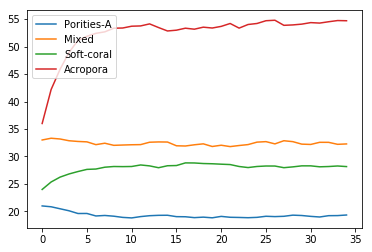

In [27]:
# Look at first replicate for each cluster
tmp = np.array([np.median(HC_projection[0].T[i],1) for i in range(ncluster)])
[plt.plot(np.arange(nyrs),tmp[i]) for i in range(ncluster)]
plt.legend(Clust_x);

### Expected long-term water quality benefit | current conditions

In [28]:
# Grab first level of water quality change (0)
tmp = np.array([WQ_projection[0].T[i] for i in range(ncluster)])

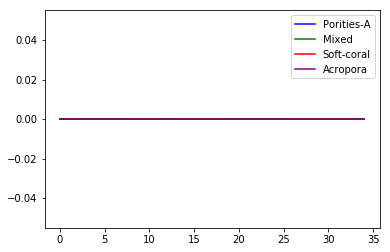

In [29]:
# Colour code
xcol = ['blue','green','red','purple']
[plt.plot(np.arange(nyrs),np.median(tmp[i],1),c=xcol[i]) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],25,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],75,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
plt.legend(Clust_names);

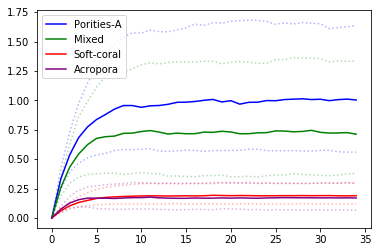

In [30]:
tmp = np.array([WQ_projection[4].T[i] for i in range(ncluster)])
# Colour code
xcol = ['blue','green','red','purple']
[plt.plot(np.arange(nyrs),np.median(tmp[i],1),c=xcol[i]) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],25,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],75,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
plt.legend(Clust_names);

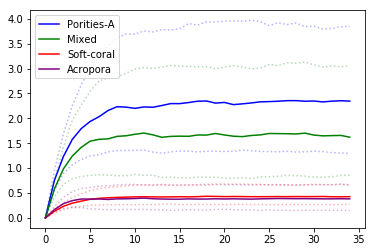

In [31]:
tmp = np.array([WQ_projection[9].T[i] for i in range(ncluster)])
# Colour code
xcol = ['blue','green','red','purple']
[plt.plot(np.arange(nyrs),np.median(tmp[i],1),c=xcol[i]) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],25,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],75,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
plt.legend(Clust_names);

In [32]:
tmp = np.array([np.median(HC_projection_nd[0].T[i],1) for i in range(ncluster)])
np.shape(tmp)

(4, 35)

In [33]:
WQ_Porities = np.array([np.median(WQ_projection[z].T[0],1) for z in range(nlin)])
WQ_Mixed = np.array([np.median(WQ_projection[z].T[1],1) for z in range(nlin)])
WQ_Acropora = np.array([np.median(WQ_projection[z].T[2],1) for z in range(nlin)])
WQ_SoftCoral = np.array([np.median(WQ_projection[z].T[3],1) for z in range(nlin)])

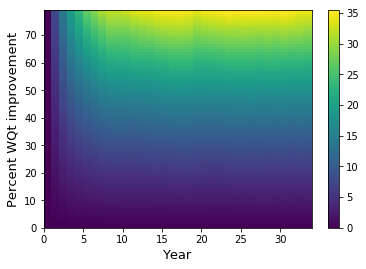

In [34]:
fig, ax = plt.subplots()
im = ax.pcolormesh(np.arange(nyrs), np.arange(nlin), WQ_Porities)
fig.colorbar(im)
ax.axis('tight')
plt.xlabel('Year',fontsize=13)
plt.xticks(label=np.arange(2015,2051,5).astype(str))
plt.ylabel('Percent WQt improvement',fontsize=13)
plt.show()

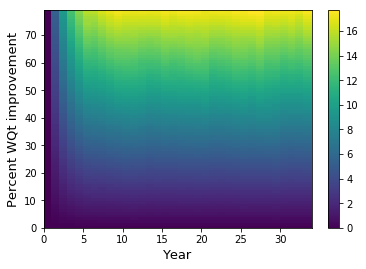

In [35]:
fig, ax = plt.subplots()
im = ax.pcolormesh(np.arange(nyrs), np.arange(nlin), WQ_Mixed)
fig.colorbar(im)
ax.axis('tight')
plt.xlabel('Year',fontsize=13)
plt.xticks(label=np.arange(2015,2051,5).astype(str))
plt.ylabel('Percent WQt improvement',fontsize=13)
plt.show()

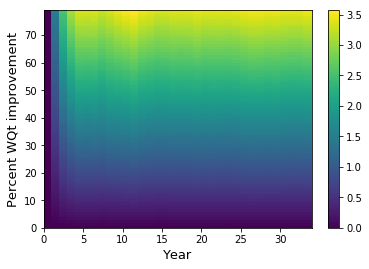

In [36]:
fig, ax = plt.subplots()
im = ax.pcolormesh(np.arange(nyrs), np.arange(nlin), WQ_SoftCoral)
fig.colorbar(im)
ax.axis('tight')
plt.xlabel('Year',fontsize=13)
plt.xticks(label=np.arange(2015,2051,5).astype(str))
plt.ylabel('Percent WQt improvement',fontsize=13)
plt.show()

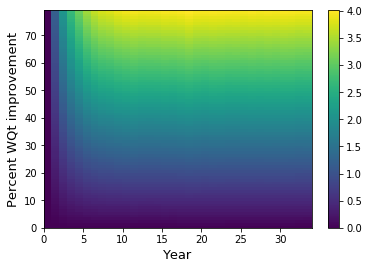

In [37]:
fig, ax = plt.subplots()
im = ax.pcolormesh(np.arange(nyrs), np.arange(nlin), WQ_Acropora)
fig.colorbar(im)
ax.axis('tight')
plt.xlabel('Year',fontsize=13)
plt.xticks(label=np.arange(2015,2051,5).astype(str))
plt.ylabel('Percent WQt improvement',fontsize=13)
plt.show()

# Simulate future dynamics given climate warming

In [38]:
# Import data
S1data = pd.read_csv('no_adaptation.csv',names=['Year','PB'])
S2data = pd.read_csv('80_yr_window.csv',names=['Year','PB'])
#S3data = pd.read_csv('1_5yr.csv',names=['Year','PB'])
S3data = pd.read_csv('hughes_proj.csv')

# New Australia-based data
S4data = pd.read_csv('Max_DHW_per_year_GBR.csv')

In [39]:
S4data.head()

,Year,AverageDHW
0,2006,1.909683
1,2007,1.859708
2,2008,1.679754
3,2009,1.785421
4,2010,2.143932


In [40]:
S4data['PB'] = S4data.AverageDHW.values/8

In [41]:
# Tidy up scenario data and make continuous

# Years to fit
xnew = np.linspace(2018, 2055, num=40, endpoint=True)

# Get smoothing functions
fS1 = interp1d(S1data.Year, S1data.PB, kind='cubic')
fS2 = interp1d(S2data.Year, S2data.PB, kind='cubic')
#fS3 = interp1d(S3data.Year, S3data.PB, kind='cubic')
fS4 = interp1d(S4data.Year, S4data.PB, kind='cubic')

# Calculate fits
S1proj = fS1(xnew)/100
S2proj = fS2(xnew)/100
S3proj = S3data.PB.values[S3data.Year.values>2014]
S4proj = fS4(xnew)/100

# Ratio projections
S1pr = S1proj/S1proj[0]
S2pr = S2proj/S2proj[0]
S3pr = S3proj/S3proj[0]
S4pr = S4proj/S4proj[0]

Here I'm going to re-scale the projections to relative to the P(Bleaching) values in 2015 for use in our scenarios

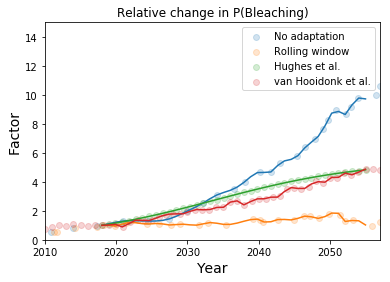

In [42]:
# Plot smoothed scenario data 
plt.scatter(S1data.Year,S1data.PB/100/S1proj[0], label='No adaptation',alpha=.2)
plt.plot(xnew,S1pr)

plt.scatter(S2data.Year,S2data.PB/100/S2proj[0], label='Rolling window',alpha=.2)
plt.plot(xnew,S2pr)

plt.scatter(xnew,S3proj/S3proj[0], label='Hughes et al.',alpha=.2)
plt.plot(xnew,S3pr)

plt.scatter(S4data.Year,S4data.PB/100/S4proj[0], label='van Hooidonk et al.',alpha=.2)
plt.plot(xnew,S4pr)

plt.xlabel('Year',fontsize=14)
plt.ylabel('Factor',fontsize=14)
plt.xlim(2010,2057)
plt.ylim(0,15)
plt.title('Relative change in P(Bleaching)')
plt.legend();

## Bleaching scenario 1 - no adaptation

In [43]:
# Create empy matrix to hold simulations
HC_projection_b1 = np.empty(shape=simshape)
HC_projection_wq_b1 = np.empty(shape=simshape)
WQ_projection_b1 = np.empty(shape=simshape)

In [44]:
# Update bleaching events to include increased ratio
x_bleach = np.array([[np.random.binomial(1,x*S1pr[y])*medianBLEACH for y in range(nyrs)] for x in np.array(p_bleach.iloc[-nsim:])])

In [45]:
# Iterate over water quality changes
for z in range(nlin):
    # Point improvement in average water quality per cluster
    cWQi = (muWQ-muWQ*z*0.01)
    # Iterate over number of simulations
    for j in range(nsim):
        # Grab random disturbance effect sizes
        g2,g3,g4,g5,g6 = beta_cots.iloc[j].values, beta_Storms[j], beta_Bleach[j], beta_Disease[j], beta_Unknown[j]
        g8,g9,g10,g11 = beta_bleach_wq[j], beta_cots_wq[j], beta_disease_wq[j], beta_unknown_wq[j]
        g12,g13,g14,g15 = beta_bleach_z[j], beta_cots_z[j], beta_disease_z[j], beta_unknown_z[j]
        # Grab random coefficients for each cluster
        r,a,bwq = r_Cluster.iloc[j].values, a_Cluster.iloc[j].values, beta_WQ[j]
        # Grab average zoning effects
        k0 = beta_zone[j]*.5
        
        # Disturbance array
        disturbs = g2*x_cots[j]+g3*x_storms[j]+g4*x_bleach[j]+g5*x_disease[j]+g6*x_unknown[j]+ g12*x_bleach[j]*.5+g13*x_cots[j]*.5+g14*x_disease[j]*.5+g15*x_unknown[j]*.5
        # Current water quality disturbance array
        disturbs2 = g8*x_bleach[j]*muWQ+g9*x_cots[j]*muWQ+g10*x_disease[j]*muWQ+g11*x_unknown[j]*muWQ
        # Improved water quality disturbance array0
        disturbs3 = g8*x_bleach[j]*cWQi+g9*x_cots[j]*cWQi+g10*x_disease[j]*cWQi+g11*x_unknown[j]*cWQi
        
        # Populate current conditions
        HC_projection_b1[z,j,0,] = HC_2017
        HC_projection_wq_b1[z,j,0,] = HC_2017
        WQ_projection_b1[z,j,0,] = HC_2017-HC_2017
        
        # Iterate over years
        for k in np.arange(1,nyrs):
                # Current condition simulations
                mu_tmp = np.exp((r+(bwq*muWQ))+(1.-a)*np.log(HC_projection_b1[z,j,k-1,]+1)+disturbs[k]+disturbs2[k])
                mu_tmp[mu_tmp>100] = 100
                # Improved water quality simulations
                mu_tmp_wq = np.exp((r+(bwq*cWQi))+(1.-a)*np.log(HC_projection_wq_b1[z,j,k-1,]+1)+disturbs[k]+disturbs3[k])
                mu_tmp_wq[mu_tmp_wq>100] = 100

                # HC in year k
                HC_projection_b1[z,j,k,] = mu_tmp
                HC_projection_wq_b1[z,j,k,] = mu_tmp_wq
                WQ_projection_b1[z,j,k,] = HC_projection_wq_b1[z,j,k,]-HC_projection_b1[z,j,k,]
            

In [46]:
# Dump results 
HC_projection_b1.dump("HC_projection_b1.dat")
HC_projection_wq_b1.dump("HC_projection_wq_b1.dat")
WQ_projection_b1.dump("WQ_projection_b1.dat")

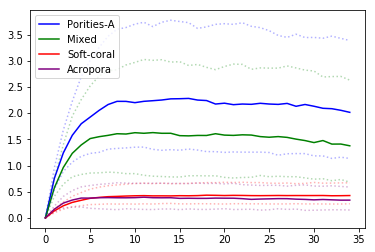

In [47]:
tmp = np.array([WQ_projection_b1[9].T[i] for i in range(ncluster)])
# Colour code
xcol = ['blue','green','red','purple']
[plt.plot(np.arange(nyrs),np.median(tmp[i],1),c=xcol[i]) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],25,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],75,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
plt.legend(Clust_names);

## Bleaching scenario 2  - 80 year window

In [48]:
# Create empy matrix to hold simulations
HC_projection_b2 = np.empty(shape=simshape)
HC_projection_wq_b2 = np.empty(shape=simshape)
WQ_projection_b2 = np.empty(shape=simshape)

In [49]:
# Update bleaching events to include increased ratio
x_bleach = np.array([[np.random.binomial(1,x*S2pr[y])*medianBLEACH for y in range(nyrs)] for x in np.array(p_bleach.iloc[-nsim:])])

In [50]:
## Iterate over water quality changes
for z in range(nlin):
    # Point improvement in average water quality per cluster
    cWQi = (muWQ-muWQ*z*0.01)
    # Iterate over number of simulations
    for j in range(nsim):
        # Grab random disturbance effect sizes
        g2,g3,g4,g5,g6 = beta_cots.iloc[j].values, beta_Storms[j], beta_Bleach[j], beta_Disease[j], beta_Unknown[j]
        g8,g9,g10,g11 = beta_bleach_wq[j], beta_cots_wq[j], beta_disease_wq[j], beta_unknown_wq[j]
        g12,g13,g14,g15 = beta_bleach_z[j], beta_cots_z[j], beta_disease_z[j], beta_unknown_z[j]
        # Grab random coefficients for each cluster
        r,a,bwq = r_Cluster.iloc[j].values, a_Cluster.iloc[j].values, beta_WQ[j]
        # Grab average zoning effects
        k0 = beta_zone[j]*.5
        
        # Disturbance array
        disturbs = g2*x_cots[j]+g3*x_storms[j]+g4*x_bleach[j]+g5*x_disease[j]+g6*x_unknown[j]+ g12*x_bleach[j]*.5+g13*x_cots[j]*.5+g14*x_disease[j]*.5+g15*x_unknown[j]*.5
        # Current water quality disturbance array
        disturbs2 = g8*x_bleach[j]*muWQ+g9*x_cots[j]*muWQ+g10*x_disease[j]*muWQ+g11*x_unknown[j]*muWQ
        # Improved water quality disturbance array0
        disturbs3 = g8*x_bleach[j]*cWQi+g9*x_cots[j]*cWQi+g10*x_disease[j]*cWQi+g11*x_unknown[j]*cWQi
        
        # Populate current conditions
        HC_projection_b2[z,j,0,] = HC_2017
        HC_projection_wq_b2[z,j,0,] = HC_2017
        WQ_projection_b2[z,j,0,] = HC_2017-HC_2017
        
        # Iterate over years
        for k in np.arange(1,nyrs):
                # Current condition simulations
                mu_tmp = np.exp((r+(bwq*muWQ))+(1.-a)*np.log(HC_projection_b2[z,j,k-1,]+1)+disturbs[k]+disturbs2[k])
                mu_tmp[mu_tmp>100] = 100
                # Improved water quality simulations
                mu_tmp_wq = np.exp((r+(bwq*cWQi))+(1.-a)*np.log(HC_projection_wq_b2[z,j,k-1,]+1)+disturbs[k]+disturbs3[k])
                mu_tmp_wq[mu_tmp_wq>100] = 100

                # HC in year k
                HC_projection_b2[z,j,k,] = mu_tmp
                HC_projection_wq_b2[z,j,k,] = mu_tmp_wq
                WQ_projection_b2[z,j,k,] = HC_projection_wq_b2[z,j,k,]-HC_projection_b2[z,j,k,]

In [51]:
# Dump results 
HC_projection_b2.dump("HC_projection_b2.dat")
HC_projection_wq_b2.dump("HC_projection_wq_b2.dat")
WQ_projection_b2.dump("WQ_projection_b2.dat")

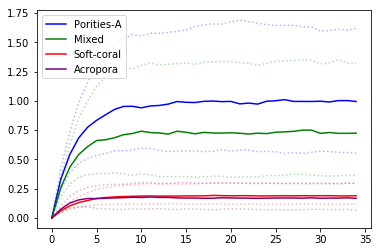

In [52]:
tmp = np.array([WQ_projection_b2[4].T[i] for i in range(ncluster)])
# Colour code
xcol = ['blue','green','red','purple']
[plt.plot(np.arange(nyrs),np.median(tmp[i],1),c=xcol[i]) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],25,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],75,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
plt.legend(Clust_names);

## Bleaching scenario 3 - Hughes et al.

In [53]:
# Create empy matrix to hold simulations
HC_projection_b3 = np.empty(shape=simshape)
HC_projection_wq_b3 = np.empty(shape=simshape)
WQ_projection_b3 = np.empty(shape=simshape)

In [54]:
# Update bleaching events to include increased ratio
x_bleach = np.array([[np.random.binomial(1,x*S3pr[y])*medianBLEACH for y in range(nyrs)] for x in np.array(p_bleach.iloc[-nsim:])])

In [55]:
## Iterate over water quality changes
for z in range(nlin):
    # Point improvement in average water quality per cluster
    cWQi = (muWQ-muWQ*z*0.01)
    # Iterate over number of simulations
    for j in range(nsim):
        # Grab random disturbance effect sizes
        g2,g3,g4,g5,g6 = beta_cots.iloc[j].values, beta_Storms[j], beta_Bleach[j], beta_Disease[j], beta_Unknown[j]
        g8,g9,g10,g11 = beta_bleach_wq[j], beta_cots_wq[j], beta_disease_wq[j], beta_unknown_wq[j]
        g12,g13,g14,g15 = beta_bleach_z[j], beta_cots_z[j], beta_disease_z[j], beta_unknown_z[j]
        # Grab random coefficients for each cluster
        r,a,bwq = r_Cluster.iloc[j].values, a_Cluster.iloc[j].values, beta_WQ[j]
        # Grab average zoning effects
        k0 = beta_zone[j]*.5
        
        # Disturbance array
        disturbs = g2*x_cots[j]+g3*x_storms[j]+g4*x_bleach[j]+g5*x_disease[j]+g6*x_unknown[j]+ g12*x_bleach[j]*.5+g13*x_cots[j]*.5+g14*x_disease[j]*.5+g15*x_unknown[j]*.5
        # Current water quality disturbance array
        disturbs2 = g8*x_bleach[j]*muWQ+g9*x_cots[j]*muWQ+g10*x_disease[j]*muWQ+g11*x_unknown[j]*muWQ
        # Improved water quality disturbance array0
        disturbs3 = g8*x_bleach[j]*cWQi+g9*x_cots[j]*cWQi+g10*x_disease[j]*cWQi+g11*x_unknown[j]*cWQi
        
        # Populate current conditions
        HC_projection_b3[z,j,0,] = HC_2017
        HC_projection_wq_b3[z,j,0,] = HC_2017
        WQ_projection_b3[z,j,0,] = HC_2017-HC_2017
        
        # Iterate over years
        for k in np.arange(1,nyrs):
                # Current condition simulations
                mu_tmp = np.exp((r+(bwq*muWQ))+(1.-a)*np.log(HC_projection_b3[z,j,k-1,]+1)+disturbs[k]+disturbs2[k])
                mu_tmp[mu_tmp>100] = 100
                # Improved water quality simulations
                mu_tmp_wq = np.exp((r+(bwq*cWQi))+(1.-a)*np.log(HC_projection_wq_b3[z,j,k-1,]+1)+disturbs[k]+disturbs3[k])
                mu_tmp_wq[mu_tmp_wq>100] = 100

                # HC in year k
                HC_projection_b3[z,j,k,] = mu_tmp
                HC_projection_wq_b3[z,j,k,] = mu_tmp_wq
                WQ_projection_b3[z,j,k,] = HC_projection_wq_b3[z,j,k,]-HC_projection_b3[z,j,k,]

In [56]:
# Dump results 
HC_projection_b3.dump("HC_projection_b3.dat")
HC_projection_wq_b3.dump("HC_projection_wq_b3.dat")
WQ_projection_b3.dump("WQ_projection_b3.dat")

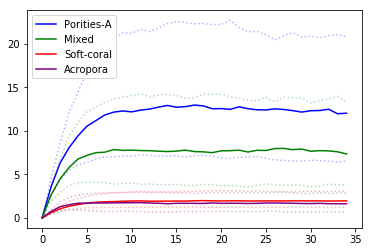

In [57]:
tmp = np.array([WQ_projection_b3[40].T[i] for i in range(ncluster)])
# Colour code
xcol = ['blue','green','red','purple']
[plt.plot(np.arange(nyrs),np.median(tmp[i],1),c=xcol[i]) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],25,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],75,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
plt.legend(Clust_names);

## Bleaching scenario 4 - van Hooidonk et al.

In [58]:
# Create empy matrix to hold simulations
HC_projection_b4 = np.empty(shape=simshape)
HC_projection_wq_b4 = np.empty(shape=simshape)
WQ_projection_b4 = np.empty(shape=simshape)

In [59]:
# Update bleaching events to include increased ratio
x_bleach = np.array([[np.random.binomial(1,x*S4pr[y])*medianBLEACH for y in range(nyrs)] for x in np.array(p_bleach.iloc[-nsim:])])

In [60]:
## Iterate over water quality changes
for z in range(nlin):
    # Point improvement in average water quality per cluster
    cWQi = (muWQ-muWQ*z*0.01)
    # Iterate over number of simulations
    for j in range(nsim):
        # Grab random disturbance effect sizes
        g2,g3,g4,g5,g6 = beta_cots.iloc[j].values, beta_Storms[j], beta_Bleach[j], beta_Disease[j], beta_Unknown[j]
        g8,g9,g10,g11 = beta_bleach_wq[j], beta_cots_wq[j], beta_disease_wq[j], beta_unknown_wq[j]
        g12,g13,g14,g15 = beta_bleach_z[j], beta_cots_z[j], beta_disease_z[j], beta_unknown_z[j]
        # Grab random coefficients for each cluster
        r,a,bwq = r_Cluster.iloc[j].values, a_Cluster.iloc[j].values, beta_WQ[j]
        # Grab average zoning effects
        k0 = beta_zone[j]*.5
        
        # Disturbance array
        disturbs = g2*x_cots[j]+g3*x_storms[j]+g4*x_bleach[j]+g5*x_disease[j]+g6*x_unknown[j]+ g12*x_bleach[j]*.5+g13*x_cots[j]*.5+g14*x_disease[j]*.5+g15*x_unknown[j]*.5
        # Current water quality disturbance array
        disturbs2 = g8*x_bleach[j]*muWQ+g9*x_cots[j]*muWQ+g10*x_disease[j]*muWQ+g11*x_unknown[j]*muWQ
        # Improved water quality disturbance array0
        disturbs3 = g8*x_bleach[j]*cWQi+g9*x_cots[j]*cWQi+g10*x_disease[j]*cWQi+g11*x_unknown[j]*cWQi
        
        # Populate current conditions
        HC_projection_b4[z,j,0,] = HC_2017
        HC_projection_wq_b4[z,j,0,] = HC_2017
        WQ_projection_b4[z,j,0,] = HC_2017-HC_2017
        
        # Iterate over years
        for k in np.arange(1,nyrs):
                # Current condition simulations
                mu_tmp = np.exp((r+(bwq*muWQ))+(1.-a)*np.log(HC_projection_b4[z,j,k-1,]+1)+disturbs[k]+disturbs2[k])
                mu_tmp[mu_tmp>100] = 100
                # Improved water quality simulations
                mu_tmp_wq = np.exp((r+(bwq*cWQi))+(1.-a)*np.log(HC_projection_wq_b4[z,j,k-1,]+1)+disturbs[k]+disturbs3[k])
                mu_tmp_wq[mu_tmp_wq>100] = 100

                # HC in year k
                HC_projection_b4[z,j,k,] = mu_tmp
                HC_projection_wq_b4[z,j,k,] = mu_tmp_wq
                WQ_projection_b4[z,j,k,] = HC_projection_wq_b4[z,j,k,]-HC_projection_b4[z,j,k,]

In [61]:
# Dump results 
HC_projection_b4.dump("HC_projection_b4.dat")
HC_projection_wq_b4.dump("HC_projection_wq_b4.dat")
WQ_projection_b4.dump("WQ_projection_b4.dat")

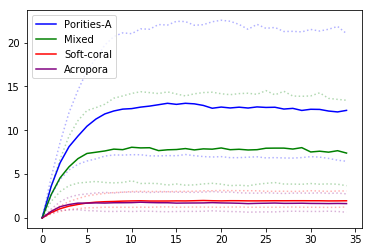

In [62]:
tmp = np.array([WQ_projection_b4[40].T[i] for i in range(ncluster)])
# Colour code
xcol = ['blue','green','red','purple']
[plt.plot(np.arange(nyrs),np.median(tmp[i],1),c=xcol[i]) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],25,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
[plt.plot(np.arange(nyrs),np.percentile(tmp[i],75,1),c=xcol[i],linestyle=":",alpha=0.3) for i in range(ncluster)]
plt.legend(Clust_names);